# LOAD USEFUL LIBRARIES

In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, save, load
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from sklearn.metrics import precision_score, recall_score, fbeta_score
from tabulate import tabulate


# DEVICE CONFIGURATION

In [306]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DEFINE GLOBAL VARIABLES

In [307]:
#NETWORKS SIZES
Input_Size_1= 100
Hidden_Size_1=60
Output_Size_1=100
Input_Size_2= 100

#PATTERNS
num_units=100
patterns_number = 200

# pre-training and hyperparamentes
learning_rate_1 = 0.9
learning_rate_2 = 0.1
n_epochs = 150
momentum=0.0
temperature=1.0

#Testing
First_set=[]
Second_set=[]
Third_set=[]

First_set_targets=[]
Second_set_targets=[]
Third_set_targets=[]


#GRAPHIC OF PRETRAINING
epoch_list = list(range(1, n_epochs + 1))
epoch_1_order= np.zeros(n_epochs)
epoch_2_order= np.zeros(n_epochs)
patterns_matrix= np.zeros((n_epochs, patterns_number))


# SIGMOID FUNCTION DEFINITION

In [308]:
class CustomSigmoid(nn.Module):
    def __init__(self):
        super(CustomSigmoid, self).__init__()
        self.temperature = 1.0

    def forward(self, x):
        sigmoid_output = 1 / (1 + torch.exp(-x / self.temperature))
        return sigmoid_output

# FIRST ORDER NETWORK ARCHITECTURE DEFINITION

In [309]:
class FirstOrderNetwork(nn.Module):

    def __init__(self, input_size, hidden_size , output_size):
        super(FirstOrderNetwork, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.activation = CustomSigmoid()

        nn.init.uniform_(self.input_layer.weight, -1.0, 1.0)
        nn.init.uniform_(self.hidden_layer.weight, -1.0, 1.0)
        nn.init.uniform_(self.output_layer.weight, -1.0, 1.0)

    def forward(self, x):

        out = self.activation(self.input_layer(x))
        out = self.activation(self.hidden_layer(out))
        out = self.activation(self.output_layer(out))
        #out = torch.where(out > 0.5, 1.0, out )
        out = torch.where(out > 0.5, out + 0.12, out )

        return out

# SECOND ORDER NETWORK ARCHITECTURE DEFINITION

In [310]:
class SecondOrderNetwork(nn.Module):
    def __init__(self, input_size):

        super(SecondOrderNetwork, self).__init__()
        self.comparison_layer = nn.Linear(input_size, input_size)
        self.wager = nn.Linear(input_size , 1)
        self.activation = CustomSigmoid()

        nn.init.uniform_(self.comparison_layer.weight, -1.0, 1.0)
        nn.init.uniform_(self.wager.weight, 0.0, 0.1)

    def forward(self, x):
        out = self.comparison_layer(x)
        out = self.activation(self.wager(out))

        return out

#FUNCTION THAT CREATES PATTERS AND TARGETS FOR EACH EPOCH


In [311]:

def Generate_Patterns(patterns_number, num_units):
    patterns = []
    stim_present = []
    stim_absent  = []
    order_2_pr = []

    for i in range(patterns_number):
        if i < 100:
            pattern = np.random.uniform(0.0, 0.02, num_units)
            patterns.append(pattern)
            stim_present.append(np.zeros(num_units))
            stim_absent.append( np.zeros(num_units))
            order_2_pr.append(0.0)

        else:
            stimulus_number = random.randint(0, 99)
            pattern = np.random.uniform(0.0, 0.02, num_units)
            pattern[stimulus_number] = np.random.uniform(0.0, 1.0)
            patterns.append(pattern)
            present = np.zeros(num_units)

            if pattern[stimulus_number] >= 0.5:
                order_2_pr.append(1.0)
                present[stimulus_number] = 1.0
            else:
                order_2_pr.append(0.0)
                present[stimulus_number] = 0.0

            stim_present.append(present)
            stim_absent.append( np.zeros(num_units))

    patterns_tensor = torch.Tensor(patterns)
    stim_present_tensor = torch.Tensor(stim_present)
    stim_absent_tensor= torch.Tensor(stim_absent)
    order_2_tensor = torch.Tensor(order_2_pr)

    return patterns_tensor, stim_present_tensor , stim_absent_tensor, order_2_tensor


#ASSIGNMENT OF FIRST AND SECOND ORDER NETWORK, AND DEFINITION OF CRITERIONS


In [312]:
first_order_network = FirstOrderNetwork(Input_Size_1  , Hidden_Size_1 , Output_Size_1).to(device)
second_order_network = SecondOrderNetwork(Input_Size_2 )

criterion_1 = nn.MSELoss()
criterion_2 = nn.MSELoss()

optimizer_1 = optim.SGD(first_order_network.parameters(), lr=learning_rate_1, momentum=momentum)
optimizer_2 = optim.SGD(second_order_network.parameters(), lr=learning_rate_2, momentum=momentum)



# PRE TRAINING LOOP

In [313]:

for epoch in range(n_epochs):

  patterns_tensor, stim_present_tensor , stim_absent_tensor, order_2_tensor = Generate_Patterns(patterns_number, num_units)

  output_first_order = first_order_network(patterns_tensor)
  output_second_order = second_order_network (output_first_order - patterns_tensor)

  loss_1 = criterion_1(   output_first_order  ,   stim_present_tensor    )
  loss_2 = criterion_2(   output_second_order  , order_2_tensor     )

  loss_2.backward(retain_graph=True)
  loss_1.backward()

  optimizer_2.step()
  optimizer_1.step()

  optimizer_2.zero_grad()
  optimizer_1.zero_grad()

  epoch_1_order[epoch] = loss_1
  epoch_2_order[epoch] = loss_2

  patterns_matrix[epoch]= order_2_tensor



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# LOSS PLOT

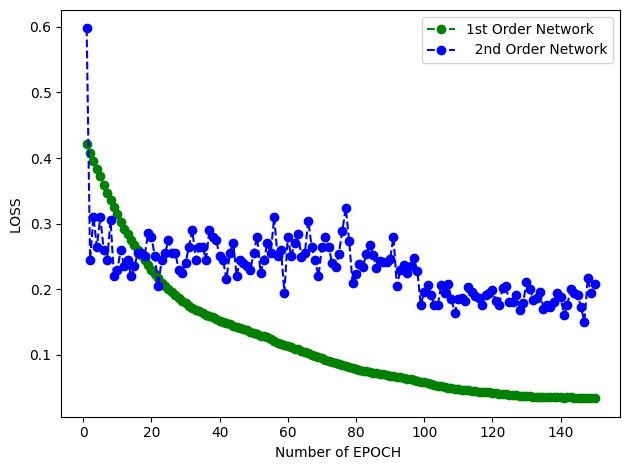

In [314]:
plt.plot(epoch_list,epoch_1_order , linestyle='--', marker='o',color='g')
plt.plot(epoch_list,epoch_2_order  , linestyle='--', marker='o',color='b')
plt.legend(['1st Order Network',  '  2nd Order Network'])
plt.xlabel('Number of EPOCH ')
plt.ylabel('LOSS ')
plt.tight_layout()
plt.show()


# PATTERNS USED (TARGETS) - HEATMAP PLOT
* It's 1.0 if the stimulus is over 0.5, and 0.0 otherwise

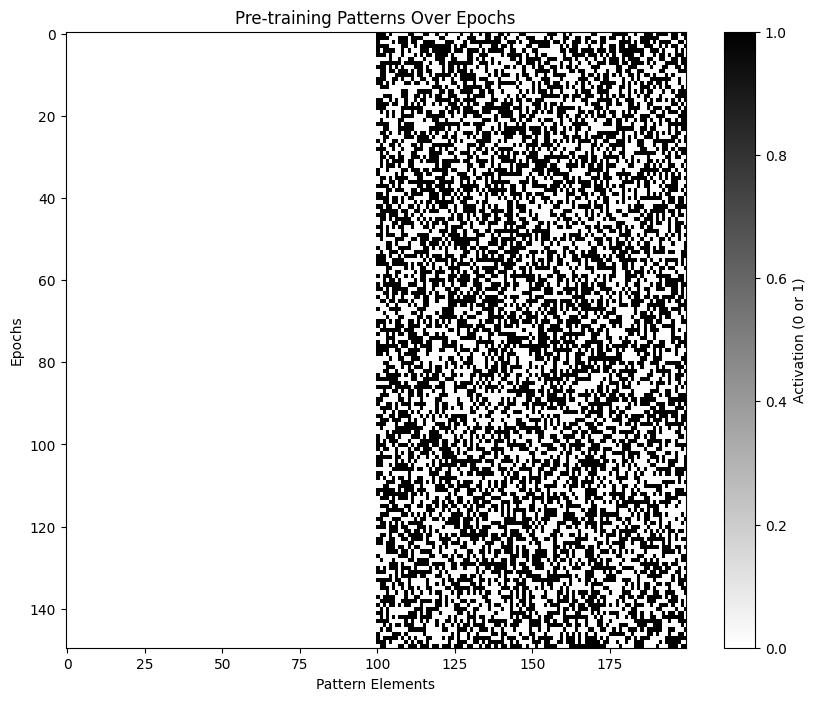

In [315]:
patterns_array = np.array(patterns_matrix)

plt.figure(figsize=(10, 8))
plt.imshow(patterns_array, cmap='binary', aspect='auto')
plt.xlabel('Pattern Elements')
plt.ylabel('Epochs')
plt.title('Pre-training Patterns Over Epochs')
plt.colorbar(label='Activation (0 or 1)')
plt.show()



# MODELS SAVING

In [316]:
PATH = './cnn1.pth'
PATH_2 = './cnn2.pth'

torch.save(first_order_network.state_dict(), PATH)
torch.save(second_order_network.state_dict(), PATH_2)


# PATTERNS FOR TESTING (Suprathreshold stimulus)






In [317]:
patterns_tensor, stim_present_tensor , stim_absent_tensor, order_2_tensor = Generate_Patterns(patterns_number, num_units)

First_set= patterns_tensor.to(device)
First_set_targets= stim_present_tensor.to(device)

# PATTERNS FOR TESTING (Subthreshold stimulus)




In [318]:
for i in range(0, patterns_number):
  if i<100:
    pattern = np.random.uniform(0.0, 0.02, num_units)
    pattern += 0.0012
    Second_set.append(pattern)
    present = np.zeros(num_units)
    Second_set_targets.append(present)

  else:
    stimulus_number = random.randint(0, 99)
    pattern = np.random.uniform(0.0, 0.02, num_units)
    pattern += 0.0012
    pattern[stimulus_number] = np.random.uniform(0.0, 1.0) + 0.0012
    Second_set.append(pattern)
    present = np.zeros(num_units)

    if pattern[stimulus_number] >= 0.5:
        present[stimulus_number] = 1.0
    else:
        present[stimulus_number] = 0.0

    Second_set_targets.append(present)

Second_set= torch.Tensor(Second_set).to(device)
Second_set_targets= Second_set.to(device)


# PATTERNS FOR TESTING (Low Vision)


In [319]:
for i in range(0, patterns_number):
  if i<100:
    pattern = np.random.uniform(0.0, 0.02, num_units)
    Third_set.append(pattern)
    present = np.zeros(num_units)
    Third_set_targets.append(present)

  else:
    stimulus_number = random.randint(0, 99)
    pattern = np.random.uniform(0.0, 0.02, num_units)
    pattern[stimulus_number] = np.random.uniform(0.0, 0.3)
    Third_set.append(pattern)
    present = np.zeros(num_units)

    if pattern[stimulus_number] >= 0.15:
        present[stimulus_number] = 1.0
    else:
        present[stimulus_number] = 0.0

    Third_set_targets.append(present)

Third_set= patterns_tensor.to(device)
Third_set_targets= stim_present_tensor.to(device)

# MODEL LOADING AND PREPARISSON FOR EVALUATION

In [320]:
Testing_patterns= [ [First_set , First_set_targets] , [Second_set , Second_set_targets] ,  [Third_set , Third_set_targets]]
Testing_graph_names= [ "Suprathreshold stimulus" ,  "Subthreshold stimulus" ,"Low Vision"]

n_samples = len(Testing_patterns[0][0])

loaded_model = FirstOrderNetwork(Input_Size_1  , Hidden_Size_1 , Output_Size_1)
loaded_model_2 = SecondOrderNetwork(Input_Size_2)

loaded_model.load_state_dict(torch.load(PATH))
loaded_model_2.load_state_dict(torch.load(PATH_2))

loaded_model.to(device)
loaded_model_2.to(device)

loaded_model.eval()
loaded_model_2.eval()

SecondOrderNetwork(
  (comparison_layer): Linear(in_features=100, out_features=100, bias=True)
  (wager): Linear(in_features=100, out_features=1, bias=True)
  (activation): CustomSigmoid()
)

# TESTING LOOP

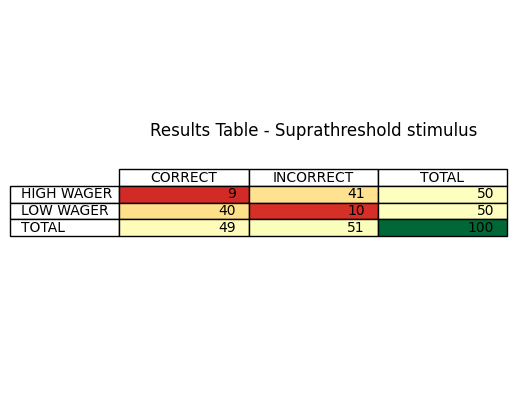

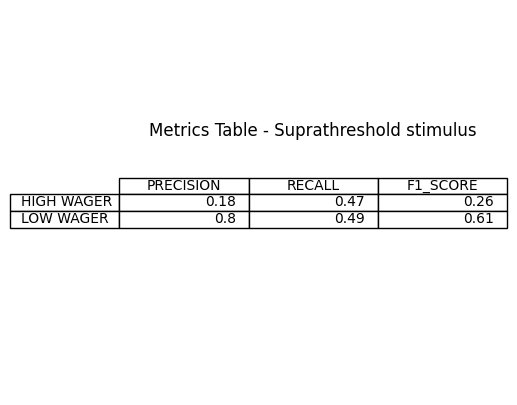

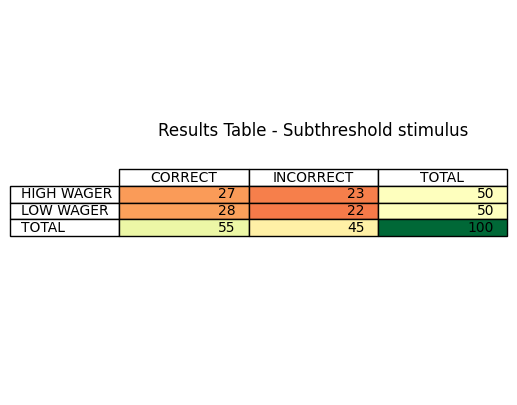

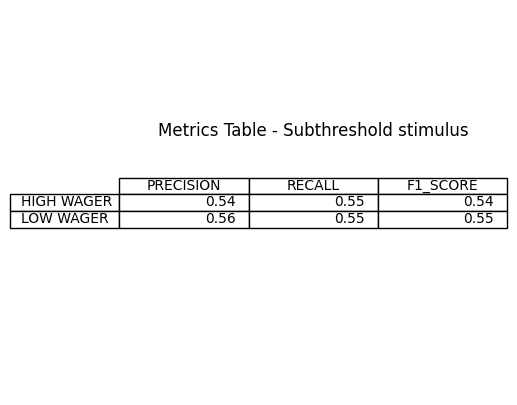

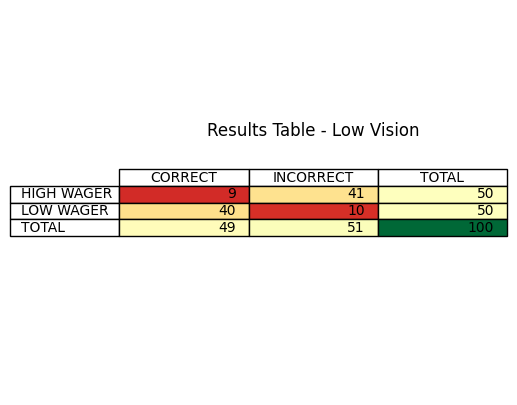

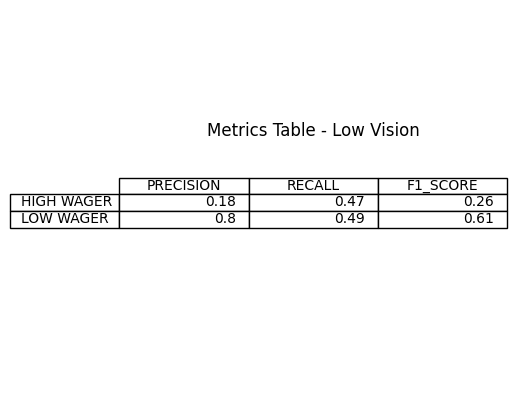

In [321]:
categories = ["HIGH WAGER", "LOW WAGER", "TOTAL"]
headers = ["CORRECT", "INCORRECT", "TOTAL"]

categories_metrics = ["HIGH WAGER", "LOW WAGER"]
headers_metrics = ["PRECISION", "RECALL", "F1_SCORE"]

for i in range(len(Testing_patterns)):

  with torch.no_grad():

      High_Wager_correct = 0
      High_Wager_incorrect = 0

      Low_Wager_correct = 0
      Low_Wager_incorrect = 0

      output_first_order = loaded_model(Testing_patterns[i][0])
      output_second_order= loaded_model_2(output_first_order - Testing_patterns[i][0])

      last_100_elements_wager = output_second_order[-100:]

      percentile_50 = np.percentile(last_100_elements_wager, 50)
      predicted = [int(1) if x >= percentile_50 else int(0) for x in last_100_elements_wager]

      _, targets_2 = torch.max(Testing_patterns[i][1] , 1)
      targets_2= targets_2[-100:]

      correlation_matrix = np.corrcoef(last_100_elements_wager.squeeze(), targets_2)
      correlation_coefficient = correlation_matrix[0, 1]

      targets_2=   [int(1) if x >= 50 else int(0) for x in targets_2]

      High_Wager_correct = sum([1 if t == 1 and p == 1 else 0 for t, p in zip(targets_2, predicted)])
      Low_Wager_correct = sum([1 if t == 0 and p == 0 else 0 for t, p in zip(targets_2, predicted)])
      High_Wager_incorrect = sum([1 if t == 0 and p == 1 else 0 for t, p in zip(targets_2, predicted)])
      Low_Wager_incorrect = sum([1 if t == 1 and p == 0 else 0 for t, p in zip(targets_2, predicted)])

      counts = [    [High_Wager_correct   , High_Wager_incorrect ,  High_Wager_correct + High_Wager_incorrect ]   ,
       [Low_Wager_correct , Low_Wager_incorrect , Low_Wager_correct + Low_Wager_incorrect  ] ,
        [High_Wager_correct + Low_Wager_correct , Low_Wager_incorrect + High_Wager_incorrect   ,  High_Wager_correct + Low_Wager_correct + Low_Wager_incorrect + High_Wager_incorrect  ]]

      colors = np.array(counts) / np.max(counts)
      colors = np.around(colors, decimals=2)
      plt.figure(figsize=(5, 5))
      plt.axis("off")
      plt.table(cellText=counts, rowLabels=categories, colLabels=headers, cellColours=plt.cm.RdYlGn(colors), loc="center")
      plt.title("Results Table - "+ Testing_graph_names[i] , y=0.65)
      plt.show()

      precision_h = round(   (High_Wager_correct ) / ( High_Wager_correct  + High_Wager_incorrect)  ,2)
      recall_h = round ( (High_Wager_correct ) / ( High_Wager_correct  + Low_Wager_incorrect)   ,2 )
      f1_score_h = round (  2 * (precision_h * recall_h)/(precision_h + recall_h)   ,2)

      precision_l = round  (   (Low_Wager_correct ) / ( Low_Wager_correct  + Low_Wager_incorrect)   ,2  )
      recall_l = round (   (Low_Wager_correct ) / ( Low_Wager_correct  + High_Wager_incorrect)    ,2)
      f1_score_l = round(  2 * (precision_l * recall_l)/(precision_l + recall_l)   ,2)

      metrics= [ [precision_h , recall_h , f1_score_h] , [precision_l , recall_l , f1_score_l]]
      plt.figure(figsize=(5, 5))
      plt.axis("off")
      plt.table(cellText=metrics, rowLabels=categories_metrics, colLabels=headers_metrics, loc="center")
      plt.title("Metrics Table - "+ Testing_graph_names[i] , y=0.65)
      plt.show()




In [ ]:
''